###### Import Libraries

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns #Visualization
import matplotlib.pyplot as plt #Visualization
from sklearn.preprocessing import StandardScaler #Standardization
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier #KNN Classifier
from sklearn.metrics import confusion_matrix 
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

###### Load Data

In [3]:
xData = pd.read_csv('../Data/Train.csv')
yData = pd.read_csv('../Data/Test.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(xData,yData,random_state=24)

In [5]:
y_train.shape

(5306, 1)

In [6]:
tl = TomekLinks(sampling_strategy='majority')
x_tl, y_tl = tl.fit_resample(X_train,y_train)
print('Original dataset shape', y_train.value_counts())
print('Resample dataset shape', y_tl.value_counts())

Original dataset shape STATUS
0         5282
1           24
dtype: int64
Resample dataset shape STATUS
0         5282
1           24
dtype: int64


In [7]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_tl, y_tl)
print('Original dataset shape', y_tl.value_counts())
print('Resample dataset shape', y_smote.value_counts())

Original dataset shape STATUS
0         5282
1           24
dtype: int64
Resample dataset shape STATUS
0         5282
1         5282
dtype: int64


###### RandomizedSearchCV Modeling

In [8]:
rf = RandomForestClassifier(random_state = 42)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [13]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_smote, y_smote)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


D:\programfiles\anaconda\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [14]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [15]:
clf = RandomForestClassifier(n_estimators = 400, min_samples_split = 5, min_samples_leaf = 1,
                            max_features = 'sqrt', max_depth = 30, bootstrap = True)
clf.fit(x_smote, y_smote)
y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))
confusion_matrix(y_test, y_pred)

C:\Users\amr_a\AppData\Local\Temp\ipykernel_25152\3351007446.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_smote, y_smote)


0.9869983041266253


array([[1741,   23],
       [   0,    5]], dtype=int64)

###### GridSearchCV Modeling

In [19]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [20]:
# Fit the grid search to the data
grid_search.fit(x_smote, y_smote)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


D:\programfiles\anaconda\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [21]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [22]:
clf = RandomForestClassifier(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 3,
                            max_features = 3, max_depth = 90, bootstrap = True)
clf.fit(x_smote, y_smote)
y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))
confusion_matrix(y_test, y_pred)

C:\Users\amr_a\AppData\Local\Temp\ipykernel_25152\761339572.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_smote, y_smote)


0.9869983041266253


array([[1741,   23],
       [   0,    5]], dtype=int64)

###### Feature Selection

In [23]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

selector = SelectFromModel(rf(n_estimators = 100, random_state = 0))
selector.fit(x_smote, y_smote)
support = selector.get_support()
features = x_smote.loc[:, support].columns.tolist()[:5]
print(features)

D:\programfiles\anaconda\lib\site-packages\sklearn\feature_selection\_from_model.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE']


In [25]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,15))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

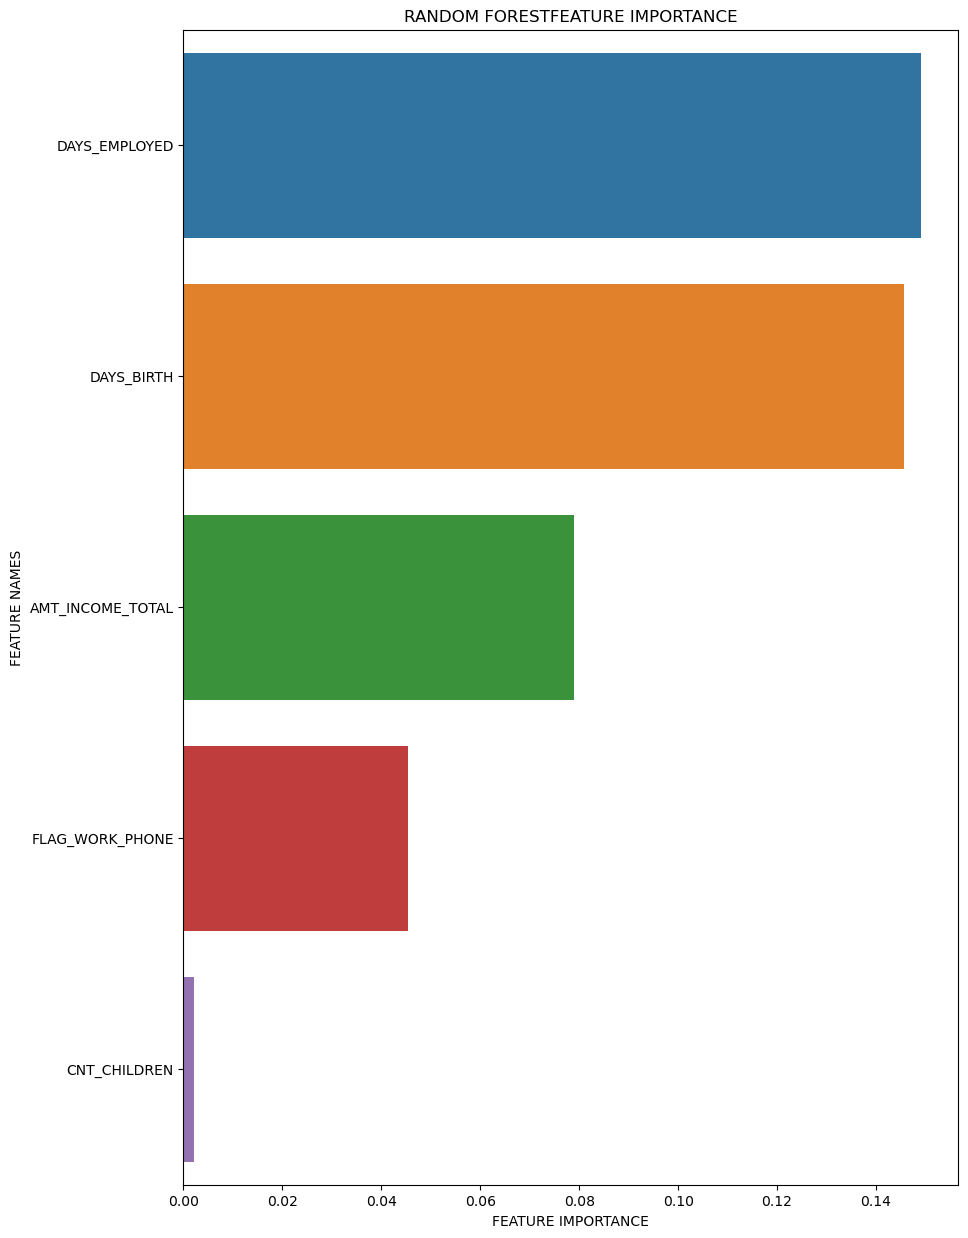

In [26]:
plot_feature_importance(clf.feature_importances_[:5],X_train.columns[:5],'RANDOM FOREST')
